In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
from models.image_vq import ImageVQ
from models.image_cluster import ImageCluster
import torch
from pytorch_lightning import LightningModule
import torch.nn as nn
from omegaconf import OmegaConf
import pytorch_lightning as pl
from rich.progress import track
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.axisbelow"] = False
matplotlib.rcParams.update({'font.size': 12})

[2024-08-24 11:54:12,084] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/MasterThesis/src/visualizations/../beit2/modeling_finetune.py:473: UserWarning: Overwriting beit_base_patch16_224 in registry with modeling_finetune.beit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def beit_base_patch16_224(pretrained=False, **kwargs):
/root/MasterThesis/src/visualizations/../beit2/modeling_finetune.py:494: UserWarning: Overwriting beit_base_patch16_384 in registry with modeling_finetune.beit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def beit_base_patch16_384(pretrained=False, **kwargs):
/root/MasterThesis/src/visualizations/../beit2/modeling_finetune.py:510: UserWarning: Overwriting beit_large_patch16_224 in registry with modeling_finetune.beit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def beit_

In [2]:
pl.seed_everything(0)

Seed set to 0


0

In [14]:
def plot_vq_classes(images, classes, classes_to_plot):
    images_per_row = 6
    num_rows = len(classes_to_plot)

    _, axes = plt.subplots(num_rows, images_per_row, figsize=(18, 3*num_rows))

    for j in range(images_per_row):
        axes[0, j].set_title(f"Example {j+1}")

    for i, label in enumerate(classes_to_plot):
        axes[i, 0].text(-0.2, 0.5, label, transform=axes[i, 0].transAxes, va='center', ha='right')

    for i, class_idx in enumerate(classes_to_plot):
        indices = (classes == class_idx).nonzero(as_tuple=False).squeeze()
        matched_images = images[indices][:images_per_row]
        for j, img in enumerate(matched_images):
            if img.dim() == 3:
                axes[i, j].imshow(img.permute(1, 2, 0))
            else:
                axes[i, j].imshow(img)
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.show()

In [4]:
MODEL_PATH = "/workspace/models/cluster.pt"

In [5]:
coco_dm_kwargs = {
    'data_path': '/workspace',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 256,
    'num_workers': 8,
    'shuffle': True,
    'drop_last': False,
}

In [6]:
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

Seed set to 42


In [7]:
coco_dm.prepare_data()
coco_dm.setup('fit')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-08-24 11:54:20 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-08-24 11:54:20 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-08-24 11:54:20 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-08-24 11:54:24 | INFO | datasets_.base_datasets | [COCOCaptions]: Load 566747 image-text pairs from /workspace/coco/coco_captioning.train.jsonl. 
2024-08-24 11:54:24 | INFO | datasets_.base_datasets | [COCOCaptions]: Load 25010 image-text pairs from /workspace/co

In [8]:
dl = iter(coco_dm.train_dataloader())

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cls:LightningModule = MODEL_REGISTRY['vq_image']['module']
model:ImageVQ = model_cls.load_from_checkpoint(MODEL_PATH).model
model = model.to(device)
model.requires_grad_(False)
model.eval()

KeyError: 'vq_image'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = OmegaConf.load('../../configs/cluster/cluster.yaml').model
model:ImageCluster = ImageCluster(cfg)
model.load_state_dict(torch.load(MODEL_PATH), strict=False)
model = model.to(device)
model.requires_grad_(False)
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-08-24 11:54:32 | INFO | utils | Loaded BEiT2 teacher state dict with result: <All keys matched successfully>


ImageCluster(
  (beitv2): VisionTransformerForMaskedImageModeling(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rel_pos_bias): RelativePositionBias()
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0

In [11]:
all_class_indices = []
all_images = []
with torch.no_grad():
    for ii, batch in enumerate(track(dl)):
        images = batch['image']
        images_raw = batch['image_raw']
        class_indices = model.get_cluster(images.to(device))['cluster_idx']
        all_class_indices.append(class_indices)
        all_images.append(images_raw)
        if ii == 100:
            break

all_class_indices = torch.cat(all_class_indices).cpu()
all_images = torch.cat(all_images).cpu()

Output()

In [12]:
all_class_indices

tensor([378, 911, 173,  ...,   0, 241, 983])

In [25]:
N=10

In [26]:
enough_members = (torch.bincount(all_class_indices, minlength=model.cluster_prototypes.shape[0]) >= 6).nonzero().squeeze()
random_indices = torch.randperm(enough_members.size(0))[:N]

classes_to_plot = enough_members[random_indices]
classes_to_plot

tensor([317, 434, 987, 684, 653, 469,  78, 199, 375, 367])

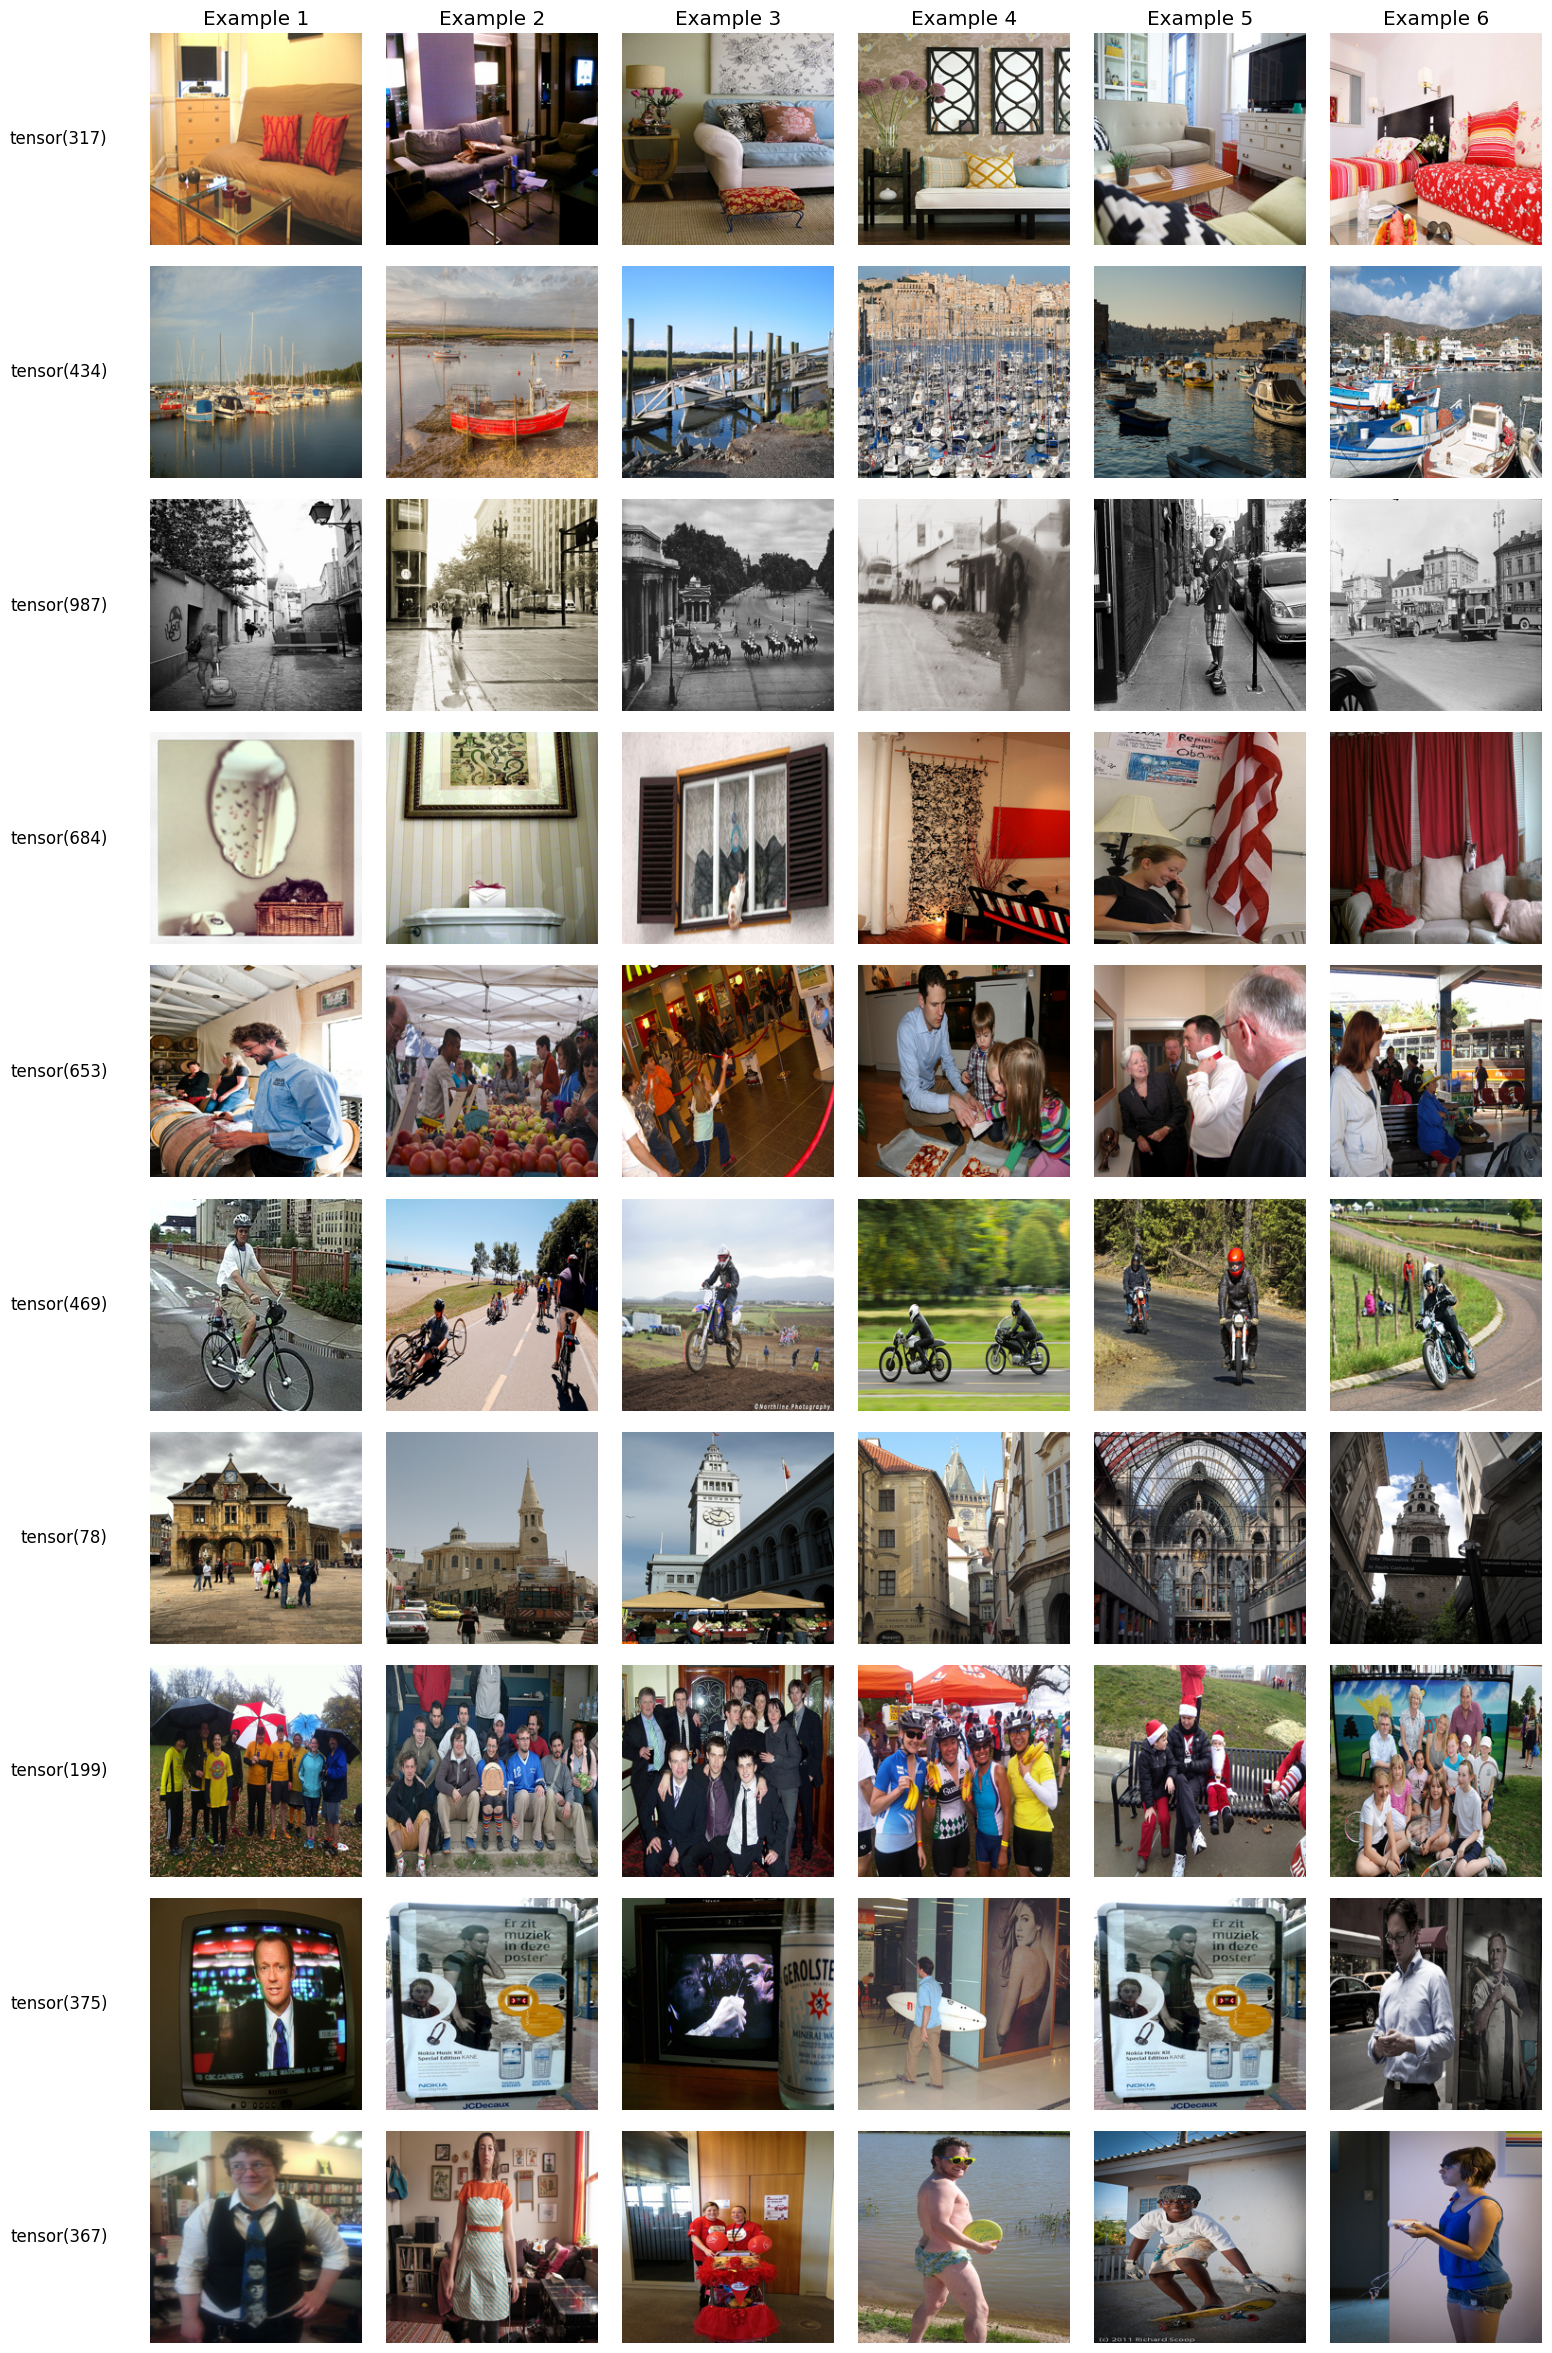

In [27]:
plot_vq_classes(images=all_images, classes=all_class_indices, classes_to_plot=classes_to_plot)